## Loading Dependencies

In [1]:
#loading basic dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
#loading the data
data = pd.read_csv('Customers_in_a_Shop.csv',header=None)
data.columns = ['Date','Customers']
data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m")
data = data.set_index('Date')

#shape of the data
data.shape

(144, 1)

## Missing Values

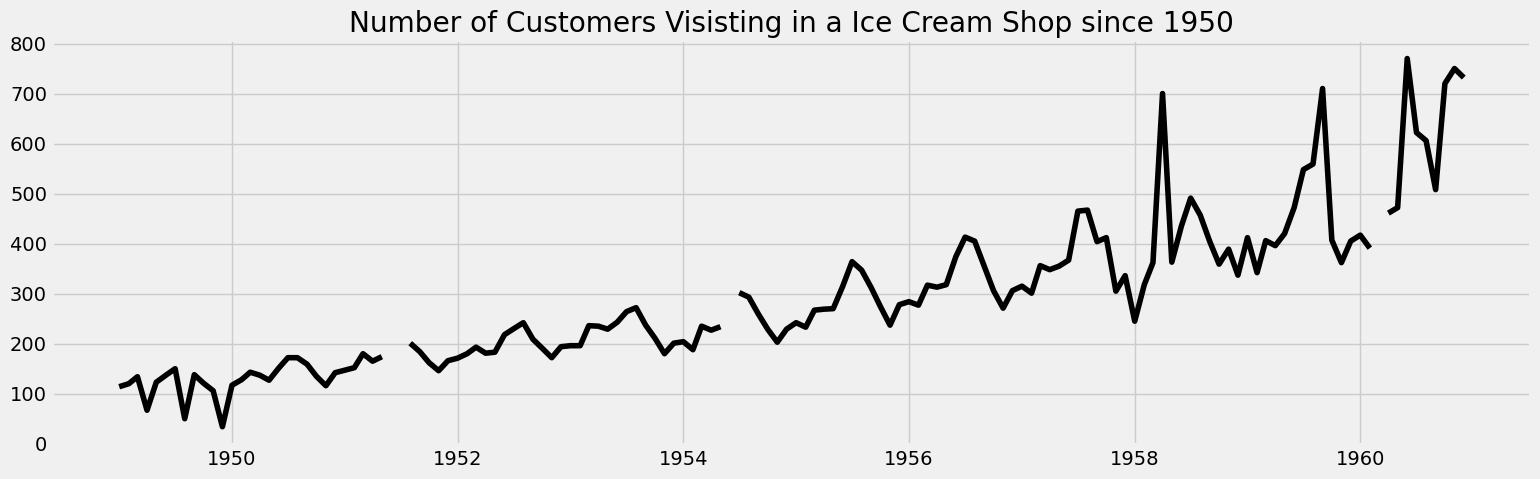

In [3]:
plt.rcParams['figure.figsize']=(17,5)
plt.plot(data,color='black')
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

## Linear Interpolation

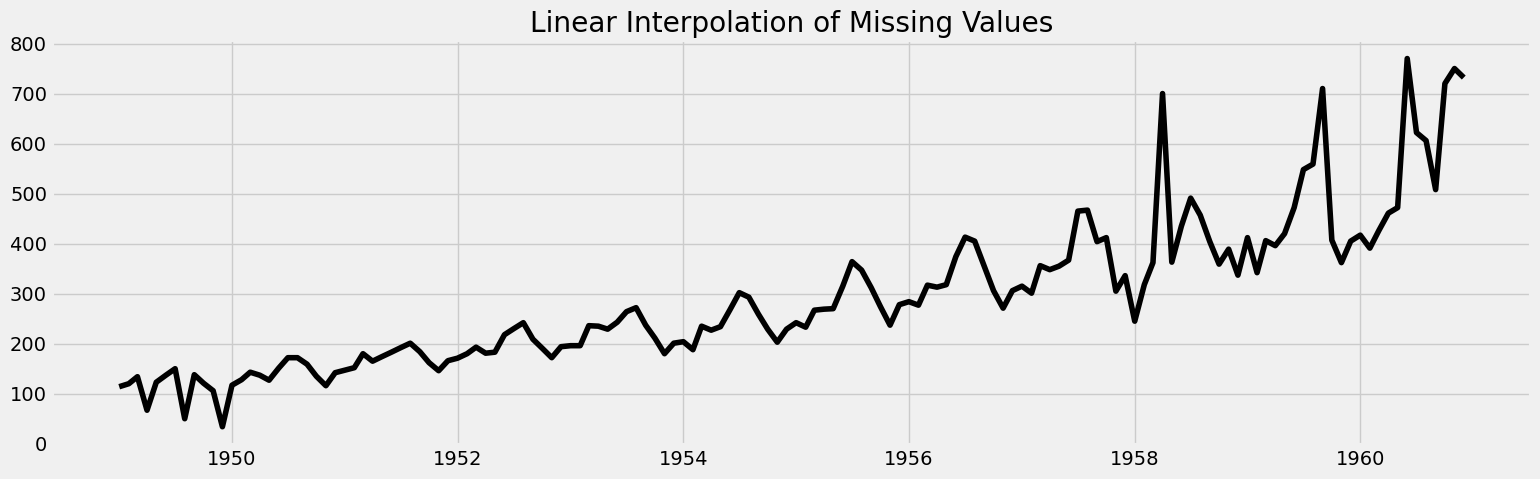

In [4]:
plt.rcParams['figure.figsize']=(17,5)
data['Customers_linear']=data['Customers'].interpolate(method='linear')
plt.plot(data['Customers_linear'],color='black')
plt.title("Linear Interpolation of Missing Values")
plt.show()

## Outliers

In [5]:
data['Customers_linear'].loc[(data['Customers_linear']>=700)] = 622

In [6]:
#getting statistical information
data.describe()

,Customers,Customers_linear
count,140.000000,144.000000
mean,291.878571,286.680556
std,150.040592,136.456487
min,34.000000,34.000000
25%,180.000000,180.750000
50%,265.500000,265.500000
75%,364.750000,364.750000
max,770.000000,622.000000


## ADF Test

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Customers_linear'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}') 

ADF Statistic: 2.7105600112832793
n_lags: 0.9990875034273379
p-value: 0.9990875034273379
Critial Values:
   1%, -3.482087964046026
Critial Values:
   5%, -2.8842185101614626
Critial Values:
   10%, -2.578864381347275


## KPSS Test

In [8]:
import warnings
warnings.filterwarnings('ignore')

#loading kpss from statsmodel
from statsmodels.tsa.stattools import kpss

result = kpss(data['Customers_linear'])
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'num lags: {result[2]}')
print('Critial Values:')
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')  


KPSS Statistic: 1.6536982710203008
p-value: 0.01
num lags: 8
Critial Values:
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


# Non-Stationary to Stationary

## Box Cox Transformation

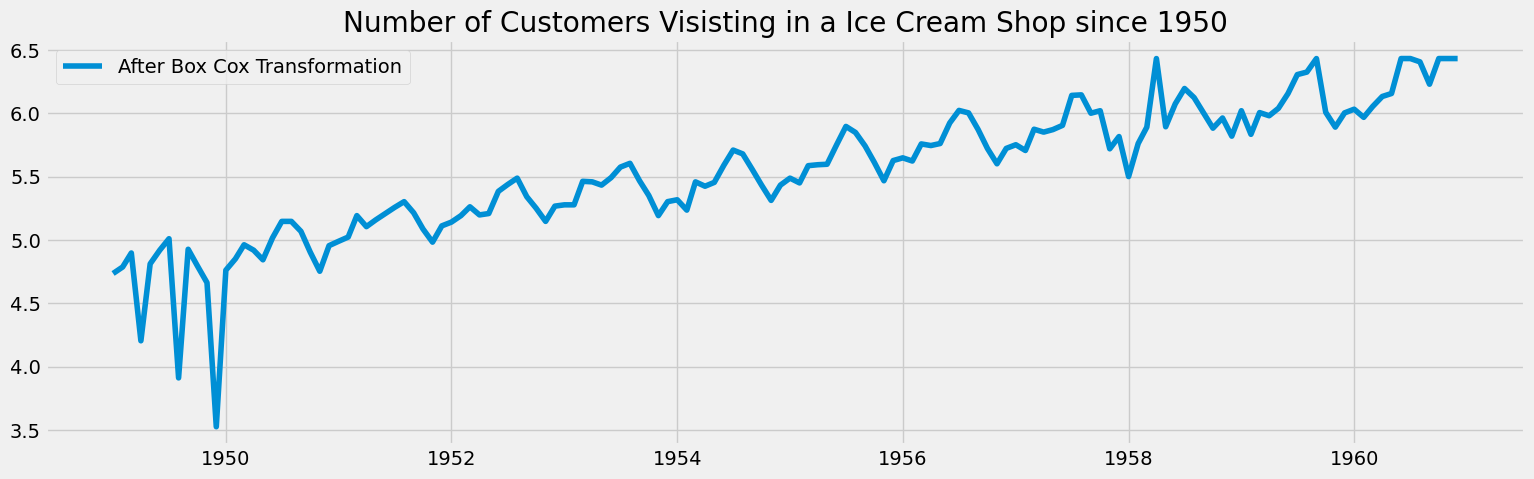

In [9]:
from scipy.stats import boxcox
data_boxcox=pd.Series(boxcox(data['Customers_linear'],lmbda=0),index=data.index)
plt.plot(data_boxcox, label="After Box Cox Transformation")
plt.legend(loc='best')
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

## Differencing

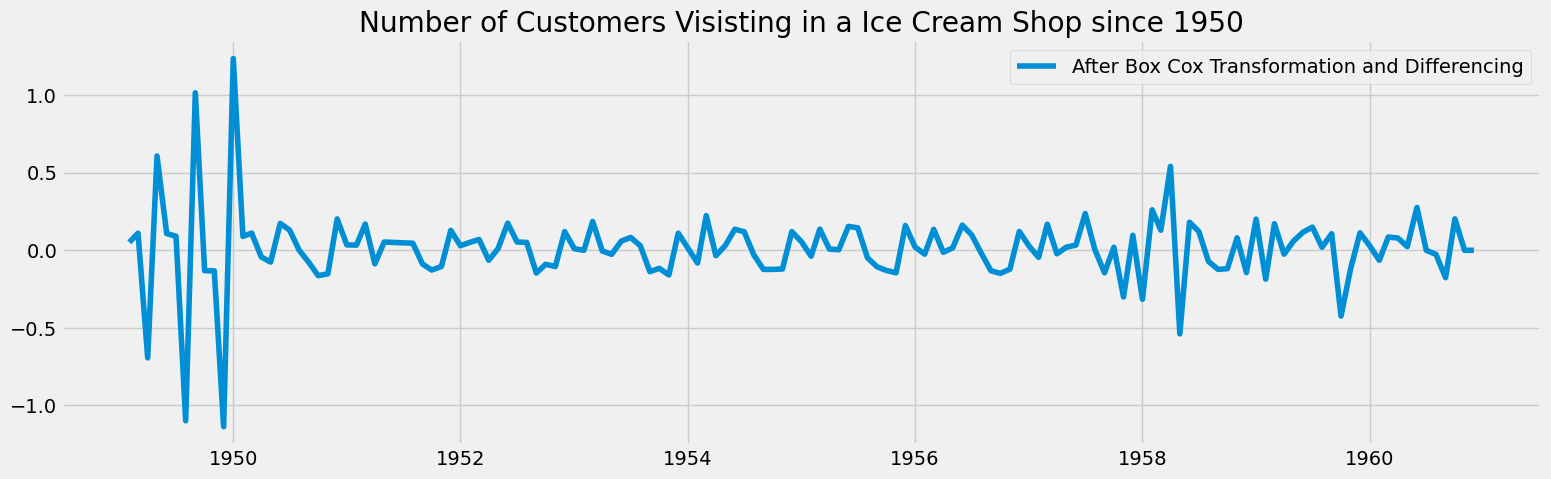

In [10]:
data_boxcox_difference= pd.Series(data_boxcox-data_boxcox.shift(), index=data.index)
data_boxcox_difference.dropna(inplace=True)
plt.plot(data_boxcox_difference, label="After Box Cox Transformation and Differencing")
plt.legend()
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

# Auto Correlation Function
ACF is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values.

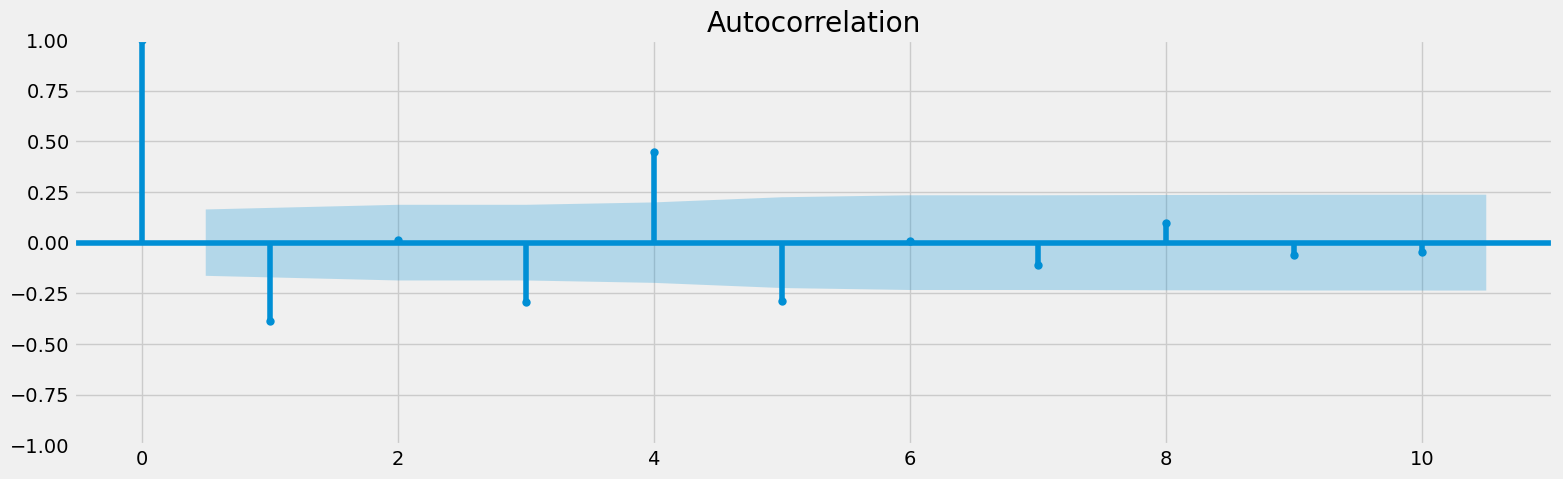

In [11]:
#Loading and plotting acf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_boxcox_difference, ax=plt.gca(), lags=10)
plt.show()

## Partial Auto Correleation Function (PACF)
Partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags.

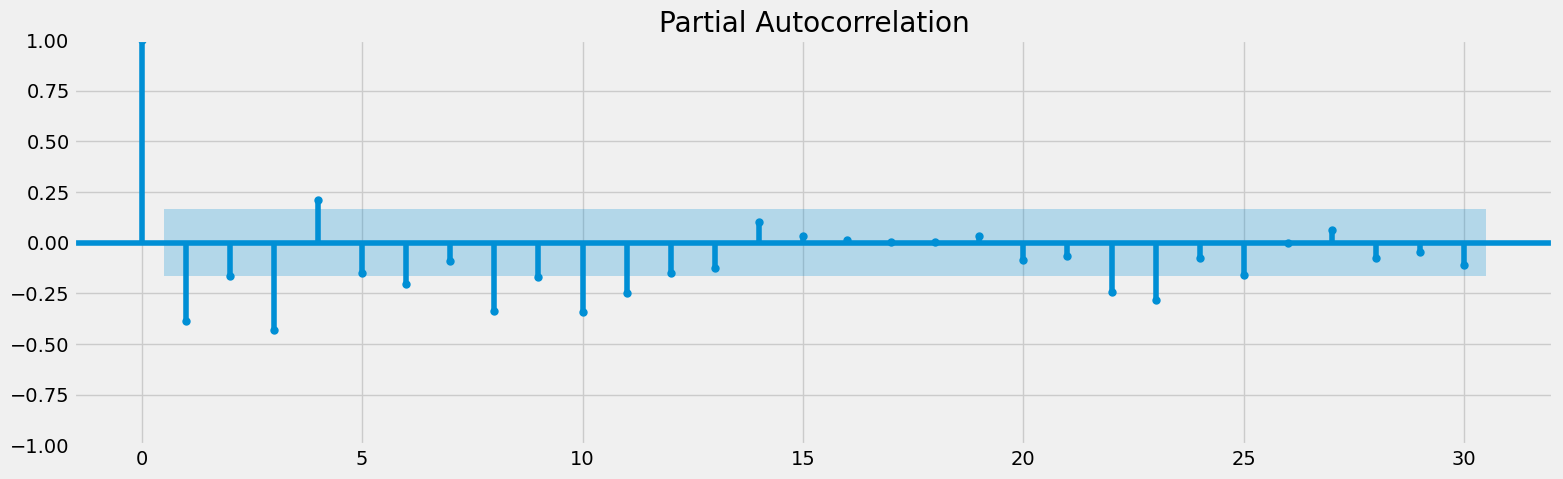

In [12]:
#Loading and plottin pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_boxcox_difference, ax=plt.gca(), lags=30)
plt.show()

## Splitting the Train and Test data

In [13]:
length_train = 115
train = data.iloc[:length_train,:]
test=data.iloc[length_train:,:]

train_data_boxcox = data_boxcox[:length_train]
test_data_boxcox = data_boxcox[length_train:]
train_data_boxcox_difference = data_boxcox_difference[:length_train-1]
test_data_boxcox_difference = data_boxcox_difference[length_train-1:]

# Auto Regressive Model
Regressive model is forecasting the future observations as a linear regression of one or more past observations.

This model has a parameter called “p” which is the lag order p that means p is the maximum number of lags that we consider in order to forecast the future observations.

Autoregressive model equation would be

y(t) = β_0 + β_1 y(t-2) + β_2 y(t-4) + β_3 y(t-6)

In [14]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA

model_ar = ARIMA(train_data_boxcox_difference, order=(1,0,0))
model_fit = model_ar.fit()
print(model_fit.params)

const     0.012435
ar.L1    -0.398531
sigma2    0.058090
dtype: float64


## Recover Original Time Series

In [15]:
y_ar_new = data_boxcox_difference.copy()
y_ar_new['ar_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(),
                                                              data_boxcox_difference.index.max())

y_ar_new['ar_forecast_boxcox'] = y_ar_new['ar_forecast_boxcox_difference'].cumsum()
y_ar_new['ar_forecast_boxcox'] = y_ar_new['ar_forecast_boxcox'].add(data_boxcox[0])
y_ar_new['ar_forecast'] = np.exp(y_ar_new['ar_forecast_boxcox'])

In [16]:
data_boxcox_difference

Date
1949-02-01    0.051293
1949-03-01    0.110348
1949-04-01   -0.693147
1949-05-01    0.607492
1949-06-01    0.107797
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01    0.202459
1960-11-01    0.000000
1960-12-01    0.000000
Length: 143, dtype: float64

In [17]:
y_ar_new['ar_forecast_boxcox_difference']

1949-02-01    0.012435
1949-03-01   -0.003051
1949-04-01   -0.026586
1949-05-01    0.293632
1949-06-01   -0.224713
                ...   
1960-08-01    0.012435
1960-09-01    0.012435
1960-10-01    0.012435
1960-11-01    0.012435
1960-12-01    0.012435
Freq: MS, Name: predicted_mean, Length: 143, dtype: float64

In [18]:
y_ar_new['ar_forecast_boxcox_difference'].cumsum()

1949-02-01    0.012435
1949-03-01    0.009385
1949-04-01   -0.017201
1949-05-01    0.276431
1949-06-01    0.051718
                ...   
1960-08-01    1.723878
1960-09-01    1.736313
1960-10-01    1.748749
1960-11-01    1.761184
1960-12-01    1.773620
Freq: MS, Name: predicted_mean, Length: 143, dtype: float64

In [19]:
y_ar_new['ar_forecast_boxcox']

1949-02-01    4.748634
1949-03-01    4.745583
1949-04-01    4.718997
1949-05-01    5.012629
1949-06-01    4.787916
                ...   
1960-08-01    6.460076
1960-09-01    6.472512
1960-10-01    6.484947
1960-11-01    6.497383
1960-12-01    6.509818
Freq: MS, Name: predicted_mean, Length: 143, dtype: float64

In [20]:
data_boxcox[0]

4.736198448394496

In [21]:
y_ar_new['ar_forecast']

1949-02-01    115.426486
1949-03-01    115.074891
1949-04-01    112.055836
1949-05-01    150.299404
1949-06-01    120.050948
                 ...    
1960-08-01    639.109946
1960-09-01    647.107149
1960-10-01    655.204422
1960-11-01    663.403016
1960-12-01    671.704199
Freq: MS, Name: predicted_mean, Length: 143, dtype: float64

## Plotting Train, Test and Forecast

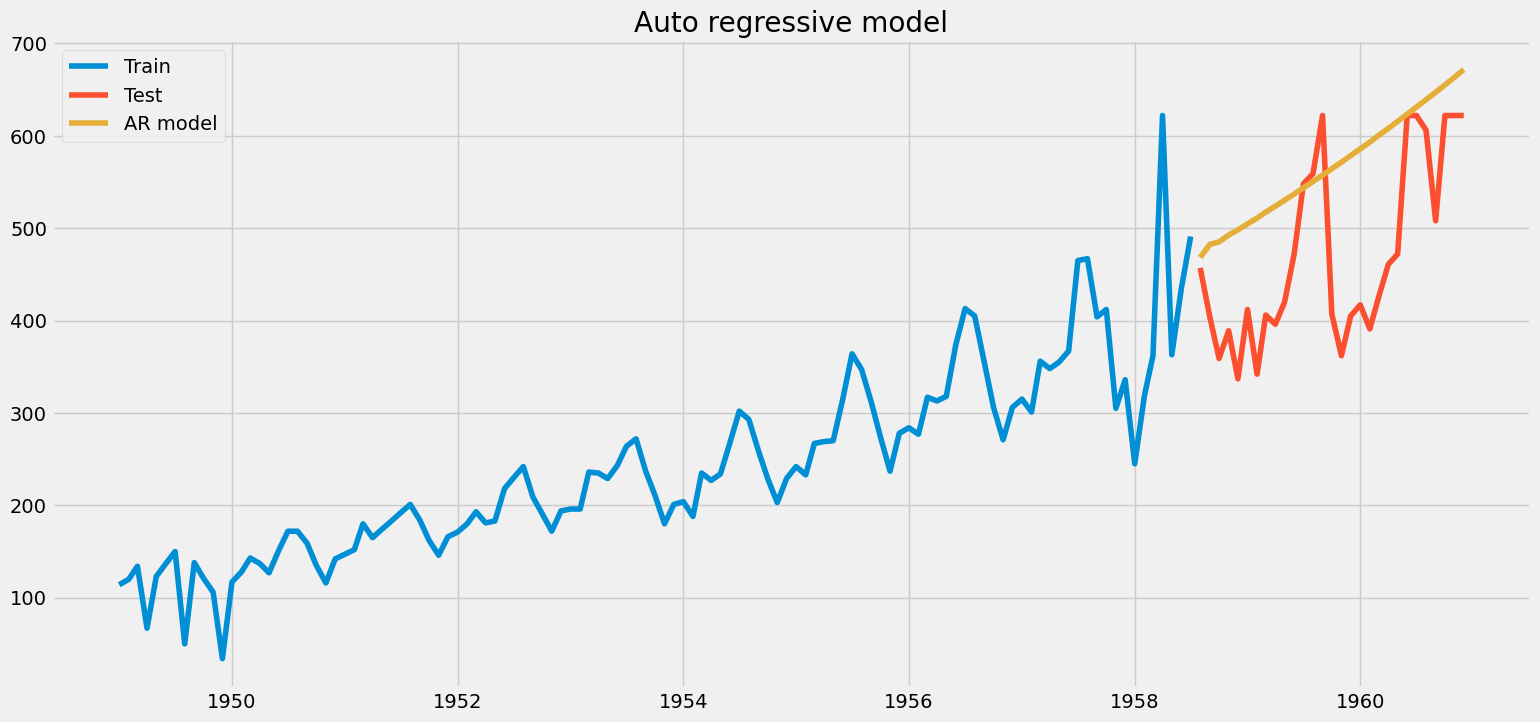

In [22]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_ar_new['ar_forecast'][test.index.min():], label = 'AR model')

plt.legend()
plt.title('Auto regressive model')
plt.show()

# Moving Average Method
In Moving Average Model, we consider the past forecasted errors to forecast the future values.

The moving average model has a parameter called “q” which is the size of the moving average window over which linear combinations of errors are calculated.

The mathematical equation is:-

y(t) = µ + φ(k)*ε(t-k)

µ is the mean of the series

ε(t-k) is the past forecasted value

φ(k) is the weight associated with error value


In [23]:
import warnings
warnings.filterwarnings('ignore')

#from statsmodels.tsa.arima_model import ARIMA

model_ma = ARIMA(train_data_boxcox_difference, order=(0,0,7))
model_fit = model_ma.fit()
print(model_fit.params)

const     0.012470
ma.L1    -0.493945
ma.L2    -0.208961
ma.L3    -0.212513
ma.L4     0.570678
ma.L5    -0.290216
ma.L6    -0.118650
ma.L7    -0.221295
sigma2    0.034786
dtype: float64


## Recover Original Series

In [24]:
y_ma_new = data_boxcox_difference.copy()
y_ma_new['ma_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(),
                                                              data_boxcox_difference.index.max())
y_ma_new['ma_forecast_boxcox'] = y_ma_new['ma_forecast_boxcox_difference'].cumsum()
y_ma_new['ma_forecast_boxcox'] = y_ma_new['ma_forecast_boxcox'].add(data_boxcox[0])
y_ma_new['ma_forecast'] = np.exp(y_ma_new['ma_forecast_boxcox'])

## Plotting Train, Test and Forecast

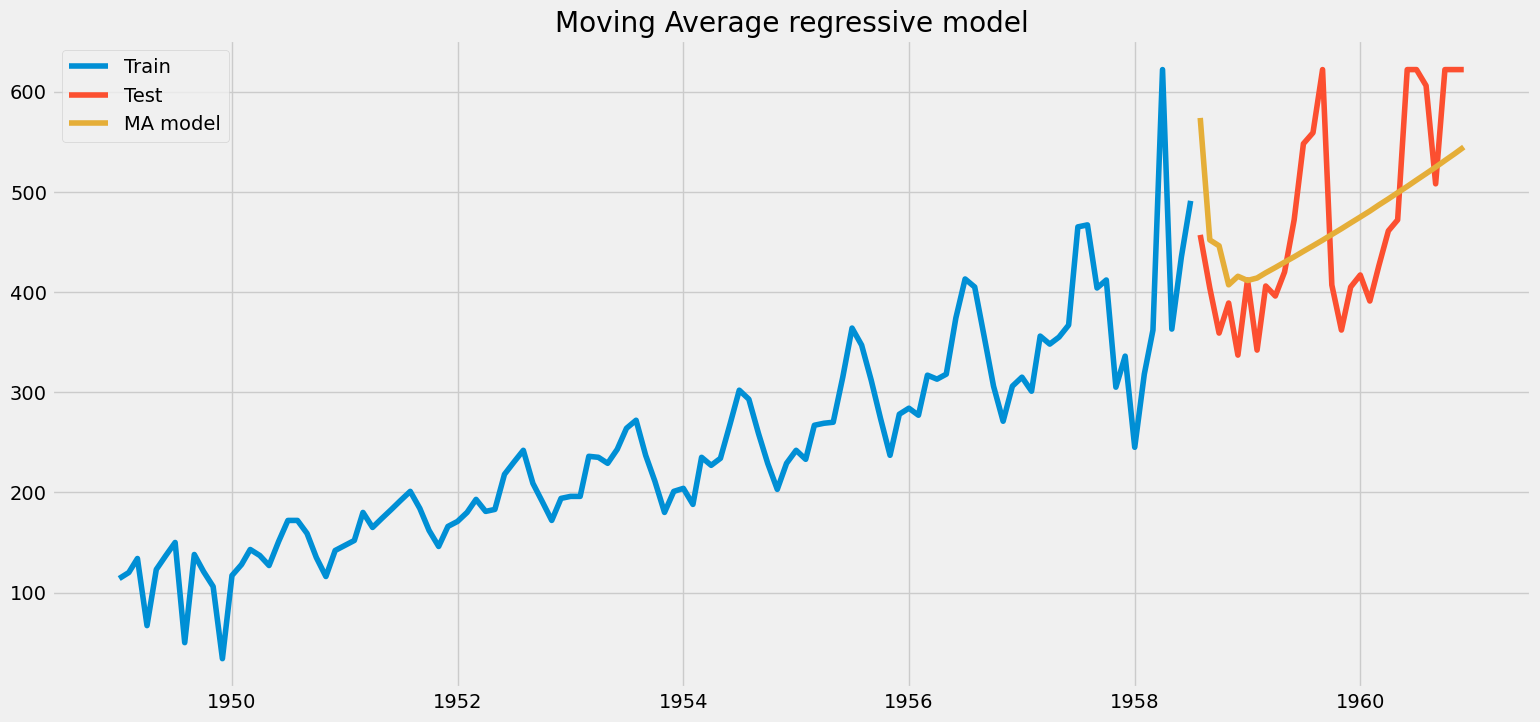

In [25]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_ma_new['ma_forecast'][test.index.min():], label = 'MA model')

plt.legend()
plt.title('Moving Average regressive model')
plt.show()